In [1]:
import torch
import torch.utils.data as torch_data

import losses
import trainer
from models import UNetGANWrap
from utils import ColorizationDataset, colorfulness_metric
import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import matplotlib.pyplot as plt
import cv2

REQUIRED_SIZE = (256, 256)
combined_dataset = torch_data.ConcatDataset(
    [
        ColorizationDataset("datasets/coco_2017_test", resize=REQUIRED_SIZE, filter_colorless=False),
        # ColorizationDataset(
        #     "datasets/imagenet_classes", resize=REQUIRED_SIZE, classes_folders=True, filter_colorless=False
        # ),
    ]
)
print("Length:", len(combined_dataset))

Length: 40670


Lenghths: 4068 406 36196
26.156716843495467


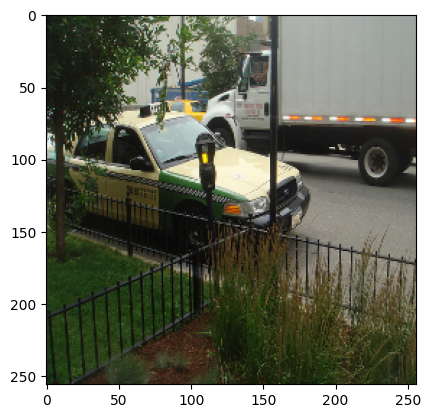

In [3]:
train_dataset, val_dataset, test_dataset = torch_data.random_split(
    combined_dataset, [0.1, 0.01, 0.89]
)  # debug lengths: 2034 407 38229
print("Lenghths:", *[len(item) for item in [train_dataset, val_dataset, test_dataset]])

L, ab = combined_dataset[0]
rgb_img = ColorizationDataset.torch_L_ab_to_cvimage(L.unsqueeze(0), ab.unsqueeze(0)).squeeze(0)
print(colorfulness_metric(rgb_img))
plt.imshow(rgb_img)
plt.show()

In [4]:
batch_size = 2

train_loader = torch_data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)
val_loader = torch_data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)

In [5]:
from fastai.vision.models import resnet18
from fastai.vision.models.unet import DynamicUnet
import torch.nn as nn
from fastai.vision.learner import create_body

def build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True):
    encoder = resnet18(weights="IMAGENET1K_V1")
    layers = [nn.Conv2d(n_input, 3, kernel_size=1)] + list(encoder.children())[:-2]
    encoder = nn.Sequential(*layers)
    
    if freeze_encoder:
        for param in encoder.parameters():
            param.requires_grad = False  # Freeze encoder weights

    net_G = DynamicUnet(encoder, n_output, (size, size), norm_type=None)
    return net_G

In [6]:
import torch.optim as optim
import torch.nn as nn
from models import UNet
from tqdm import tqdm

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_gen = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=False).to(device)
# summary(unet_gen, (1, 256, 256), device=device.type)

In [ ]:
import torch.optim as optim
import torch.nn as nn
from models import UNet
from tqdm import tqdm


criterion = nn.L1Loss()
optimizer = optim.Adam(unet_gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    unet_gen.train()
    running_loss = 0.0
    for L, ab in tqdm(train_loader):
        L = L.to(device)
        ab = ab.to(device)

        # Forward pass
        ab_pred = unet_gen(L)

        # Compute loss
        loss = criterion(ab_pred, ab)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

In [7]:
# from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetGANWrap(net_G=unet_gen, device=device)
# summary(model, input_size=(1, *REQUIRED_SIZE))

In [8]:
baseline_trainer = trainer.Trainer(
    model, train_loader, val_dataloader=val_loader, device=device,
    use_logger=False,
    use_checkpointing=True,
    checkpoit_dir="checkpoints/checkpoints_gan_loss_baseline"
)

In [ ]:
baseline_trainer.train(1)

In [9]:
model.load("checkpoints/baseline")

(DynamicUnet(
   (layers): ModuleList(
     (0): Sequential(
       (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
       (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (3): ReLU(inplace=True)
       (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (5): Sequential(
         (0): BasicBlock(
           (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu): ReLU(inplace=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (1): BasicBlock(
           (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)
torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)


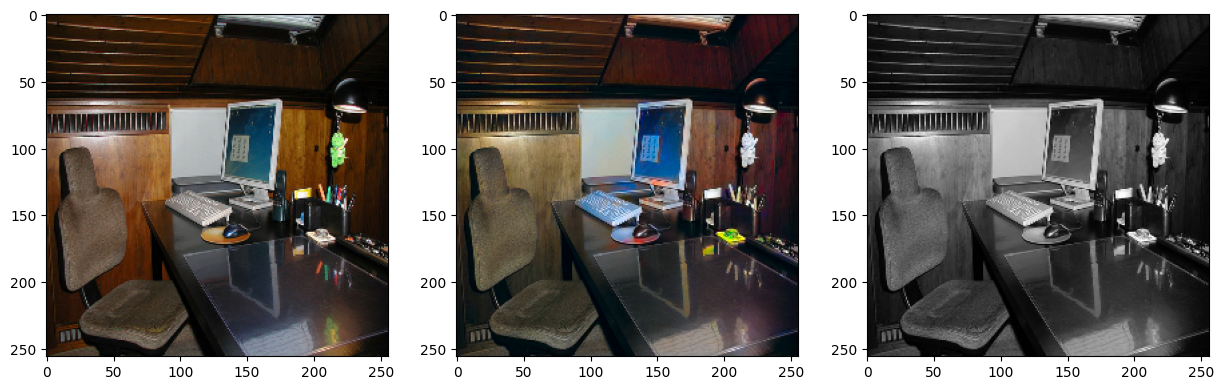

In [10]:
L, ab = test_dataset[4]

L = L.unsqueeze(0)
ab = ab.unsqueeze(0)

cielab_img_gt = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)
model.setup_input([L, ab])
ab_prediction = model.test()["fake_color"]
cielab_img_pred = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_prediction.to("cpu"))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cielab_img_gt.squeeze(0))
ax[1].imshow(cielab_img_pred.squeeze(0))
ax[2].imshow(L.squeeze(0).numpy().transpose(1, 2, 0), cmap="gray")
plt.show()

In [11]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


In [ ]:
running_loss = 0.0
for L, ab in tqdm(train_loader):
    model.setup_input([L, ab])
    ab_pred = model.test()["fake_color"]

    pred_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_pred.to("cpu"))
    gt_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)

    pred_image_tensor = torch.from_numpy(pred_image).permute(0, 3, 1, 2).float().to(device) / 255.0
    gt_image_tensor = torch.from_numpy(gt_image).permute(0, 3, 1, 2).float().to(device) / 255.0

    loss = loss_fn_alex(pred_image_tensor, gt_image_tensor).mean()
    running_loss += loss.item()

print(f"LPIPS Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 2542/2542 [05:50<00:00,  7.26it/s]

LPIPS Loss: 0.1132


In [12]:
import torch
import torch.nn.utils.prune as prune
from models import UNet

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True).to(device)
model.load_state_dict(torch.load("checkpoints/net_G.pth"))

# Apply global unstructured pruning
parameters_to_prune = []
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        parameters_to_prune.append((module, 'weight'))

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5,  # Prune 50% of weights
)

# Remove pruning reparameterization to finalize the model
for module, param in parameters_to_prune:
    prune.remove(module, 'weight')

# Save the pruned model
torch.save(model.state_dict(), "checkpoints/net_G_pruned.pth")

In [6]:
import lpips

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


In [9]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True).to(device)
model.load_state_dict(torch.load("checkpoints/net_G_pruned.pth"))

running_loss = 0.0
model.eval()
for L, ab in tqdm(val_loader):
    ab_pred = model(L.to(device))
    L = L.to("cpu")

    pred_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_pred.detach().to("cpu"))
    gt_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)

    pred_image_tensor = torch.from_numpy(pred_image).permute(0, 3, 1, 2).float().to(device) / 255.0
    gt_image_tensor = torch.from_numpy(gt_image).permute(0, 3, 1, 2).float().to(device) / 255.0

    loss = loss_fn_alex(pred_image_tensor, gt_image_tensor).mean()
    running_loss += loss.item()
    
    del L, ab, pred_image, gt_image
    torch.cuda.empty_cache()
    

print(f"LPIPS Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 203/203 [00:08<00:00, 23.11it/s]

LPIPS Loss: 0.0112


In [8]:
import torch
from models import UNet

# Load the trained model
device = torch.device("cpu")  # Quantization is typically done for CPU inference
model = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True)
model.load_state_dict(torch.load("checkpoints/net_G_pruned.pth", map_location=device))

# Fuse Conv2d and BatchNorm layers (if applicable)
# This step is necessary for quantization-aware training
model.eval()

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Conv2d, torch.nn.Linear}, dtype=torch.qint8
)

# Save the quantized model
torch.save(quantized_model.state_dict(), "checkpoints/net_G_quantized.pth")

In [ ]:
from tqdm import tqdm


running_loss = 0.0
model.eval()
for L, ab in tqdm(val_loader):
    ab_pred = quantized_model(L)

    pred_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_pred)
    gt_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)

    pred_image_tensor = torch.from_numpy(pred_image).permute(0, 3, 1, 2).float().to(device) / 255.0
    gt_image_tensor = torch.from_numpy(gt_image).permute(0, 3, 1, 2).float().to(device) / 255.0

    loss = loss_fn_alex(pred_image_tensor, gt_image_tensor).mean()
    running_loss += loss.item()
    
    del L, ab, pred_image, gt_image
    torch.cuda.empty_cache()
    

print(f"LPIPS Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import UNet

# Load the teacher model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True).to(device)
teacher_model.load_state_dict(torch.load("checkpoints/net_G.pth"))
teacher_model.eval()

# Define the student model (smaller UNet)
student_model = UNet(1, 2, n_down=6, num_filters=32).to(device)  # Smaller model
student_model.train()

# Define the distillation loss
def distillation_loss(student_output, teacher_output, target, alpha=0.5, temperature=3):
    soft_loss = nn.KLDivLoss(reduction="batchmean")(
        nn.functional.log_softmax(student_output / temperature, dim=1),
        nn.functional.softmax(teacher_output / temperature, dim=1),
    ) * (alpha * temperature * temperature)
    hard_loss = nn.MSELoss()(student_output, target) * (1 - alpha)
    return soft_loss + hard_loss

# Training loop
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
num_epochs = 10
for epoch in range(num_epochs):
    for L, ab in tqdm(train_loader):  # Assuming train_loader is defined
        L, ab = L.to(device), ab.to(device)

        # Forward pass
        with torch.no_grad():
            teacher_output = teacher_model(L)
        student_output = student_model(L)

        # Compute loss
        loss = distillation_loss(student_output, teacher_output, ab)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the distilled student model
torch.save(student_model.state_dict(), "checkpoints/net_G_distilled.pth")

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 2, n_down=6, num_filters=32).to(device)
model.load_state_dict(torch.load("checkpoints/net_G_distilled.pth"))

running_loss = 0.0
model.eval()
for L, ab in tqdm(val_loader):
    ab_pred = model(L.to(device))
    L = L.to("cpu")

    pred_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_pred.detach().to("cpu"))
    gt_image = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)

    pred_image_tensor = torch.from_numpy(pred_image).permute(0, 3, 1, 2).float().to(device) / 255.0
    gt_image_tensor = torch.from_numpy(gt_image).permute(0, 3, 1, 2).float().to(device) / 255.0

    loss = loss_fn_alex(pred_image_tensor, gt_image_tensor).mean()
    running_loss += loss.item()
    
    del L, ab, pred_image, gt_image
    torch.cuda.empty_cache()
    

print(f"LPIPS Loss: {running_loss / len(train_loader):.4f}")